In [1]:
import numpy as np
import matplotlib.pyplot as plt
import labrad_data_tools as ldt

# See data for the superscan

This example is a Ramsey contrast scan. Each data point corresponds to the contrast of a different phase scan. These contrasts were fit by the grapher to create the data of the superscan.

In [2]:
date = '20241011'
superscantime = '1626.14'

In [3]:
(x, y) = ldt.get_data(date, superscantime)

expt_name = ldt.get_experiment_name(date, superscantime)

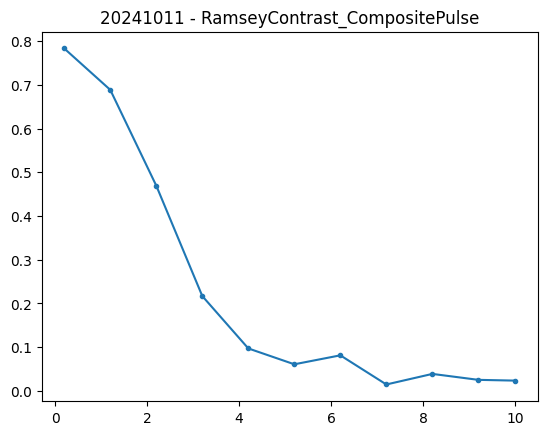

In [4]:
(fig, ax) = plt.subplots()
ax.plot(x, y, '.-', label=superscantime)
ax.set_title('{} - {}'.format(date, expt_name))
plt.show()

# See data for subscans

Now let's take a look at the underlying phase scans that were used by the grapher to fit a contrast value.

In [5]:
(x_super, subscantimes) = ldt.get_subscantimes(date, superscantime, return_xvalues=True)
print(x_super)
print(subscantimes)

[ 0.2  1.2  2.2  3.2  4.2  5.2  6.2  7.2  8.2  9.2 10. ]
['1625_30', '1626_15', '1627_00', '1627_46', '1628_31', '1629_16', '1630_01', '1630_46', '1631_31', '1632_16', '1633_01']


In [6]:
expt_name = ldt.get_experiment_name(date, subscantimes[0])

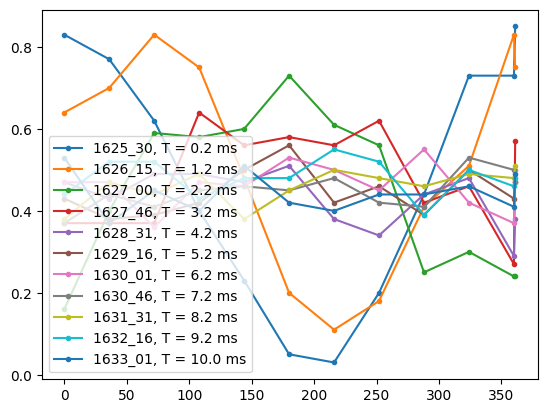

In [7]:
(fig, ax) = plt.subplots()
for (i, subscantime) in enumerate(subscantimes):
    (x, y) = ldt.get_data(date, subscantime)
    ax.plot(x, y, '.-', label='{}, T = {} ms'.format(subscantime, x_super[i]))
ax.legend()
plt.show()

We could now use `fitting_tools` to fit to the raw data ourselves rather than relying on the grapher fit.

One advantage of this is that we can start from quantum projection noise in the raw data and propagate error to get errorbars in the contrast data.

# Fitting

## Fit subscans

In [8]:
import fitting_tools as fit

In [9]:
def fit_phase_scan(date, subscantime):
    (x, y) = ldt.get_data(date, subscantime)

    fitfunc = fit.phase_scan()
    fitfunc.set_fixed_params({'offset': 0.0})
    fitfunc.set_guess_params({'phi0': 0.0,
                              'contrast': 0.5})
    fitfunc.set_fit_bounds({'contrast': (0.0, 1.0),
                            'phi0': (0.0, 360.0)})
    return fitfunc.do_fit(x, y, use_qpn=True)

In [10]:
(x_ramsey, subscantimes) = ldt.get_subscantimes(date, superscantime, return_xvalues=True)
phase_scan_fits = [fit_phase_scan(date, subscantime) for subscantime in subscantimes]
phase_scan_fits

[{'contrast': (0.6359793716054402, 0.035574244669796216),
  'phi0': (2.7592048967790934e-23, 2.157474182599385)},
 {'contrast': (0.6033621208585594, 0.037465890209885944),
  'phi0': (4.620875721033096e-25, 3.021090691502849)},
 {'contrast': (0.510416516153391, 0.03403844959819417),
  'phi0': (70.8392795964985, 4.713556124559612)},
 {'contrast': (0.22661663833215662, 0.03665561821973364),
  'phi0': (97.90240621281603, 11.005415024783115)},
 {'contrast': (0.1298901527914149, 0.040936472479924865),
  'phi0': (44.85641074704326, 17.801021706620986)},
 {'contrast': (0.08873391295140565, 0.037923667121891484),
  'phi0': (106.42730449625962, 28.1895178833544)},
 {'contrast': (0.09829357097185427, 0.04045259576126444),
  'phi0': (131.11655140948585, 24.2158109450694)},
 {'contrast': (0.03428492094028193, 0.03862265526781581),
  'phi0': (113.905952225384, 72.34272356917552)},
 {'contrast': (0.039796555128803875, 0.04405986986627823),
  'phi0': (164.26625174409915, 54.753896964994205)},
 {'contr

In [11]:
y_ramsey = [phase_scan_fit['contrast'][0] for phase_scan_fit in phase_scan_fits]
dy_ramsey = [phase_scan_fit['contrast'][1] for phase_scan_fit in phase_scan_fits]

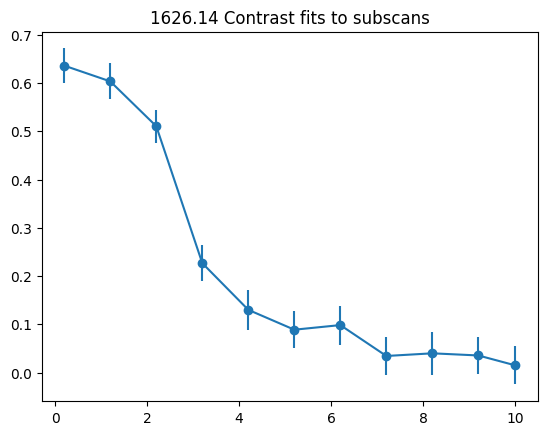

In [12]:
(fig, ax) = plt.subplots()
ax.errorbar(x_ramsey, y_ramsey, dy_ramsey, marker='o')
ax.set_title('{} Contrast fits to subscans'.format(superscantime))
plt.show()

## Fit Ramsey

Now we can take this data and fit to a function to get the coherence time. A Gaussian decay looks like it will be a decent model for this data.

In [13]:
fitfunc = fit.gaussian_decay()
fitfunc.print_parameters()

Parameters:
'tau'
'startfrom'
'decayto'


In [14]:
fitfunc.set_fixed_params({'decayto': 0.0})
fitfunc.set_guess_params({'startfrom': 0.65,
                          'tau': 3.0})
fitfunc.do_fit(x_ramsey, y_ramsey, yerr=dy_ramsey)

{'tau': (2.499655709294805, 0.1316880811419865),
 'startfrom': (0.6634362987287451, 0.027189071196598)}

The fitted coherence time is 2.5 ± 0.13 ms.

We can now evaluate the fit function with the fitted parameters to see how good it is.

In [15]:
x_ramsey_fit = np.linspace(min(x_ramsey), max(x_ramsey))
y_ramsey_fit = fitfunc.eval_with_fits(x_ramsey_fit)

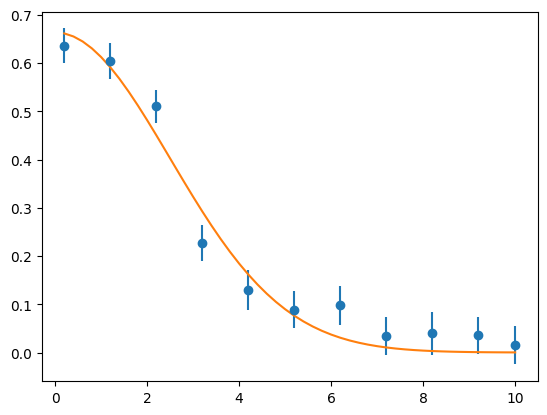

In [16]:
(fig, ax) = plt.subplots()
ax.errorbar(x_ramsey, y_ramsey, dy_ramsey, marker='o', linestyle='')
ax.plot(x_ramsey_fit, y_ramsey_fit)
plt.show()